# IMDB sentiment analysis

In [43]:
import os 
import shutil
import sys
import urllib.request
import tarfile
import re
from functools import partial

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, plot_confusion_matrix, make_scorer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.util import mark_negation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

RANDOM_SEED = 42

[nltk_data] Downloading package stopwords to /Users/jobs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jobs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jobs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data loading

In [4]:
# Set the dataset name and URL
dataset_name = "imdb"
dataset_url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# Create the dataset folder
dataset_folder = os.path.join(os.getcwd(), "datasets", dataset_name)
original_dataset_folder = os.path.join(dataset_folder, "original")
if not os.path.exists(original_dataset_folder):
    os.makedirs(original_dataset_folder)

# Create the dataframe folder
df_folder = os.path.join(dataset_folder, "dataframe")
if not os.path.exists(df_folder):
    os.makedirs(df_folder)
dataframe_path = os.path.join(df_folder, dataset_name + ".pkl")

In [5]:
# Download and extract the dataset
original_dataset_path = os.path.join(original_dataset_folder, "movies.tar.gz")
if not os.path.exists(original_dataset_path):
    urllib.request.urlretrieve(dataset_url, original_dataset_path)
    print("Successful download")
    tar = tarfile.open(original_dataset_path)
    tar.extractall(original_dataset_folder)
    extracted_folder_name = tar.getnames()[0]
    tar.close()
    print("Successful extraction")
else:
    print("Dataset already downloaded and extracted")

Dataset already downloaded and extracted


In [6]:
if not os.path.exists(dataframe_path):
    dataframe_rows = []
    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            folder = os.path.join(original_dataset_folder, extracted_folder_name, split, sentiment)
            for filename in os.listdir(folder):
                file_path = os.path.join(folder, filename)
                try:
                    if os.path.isfile(file_path):
                        with open(file_path, mode='r', encoding='utf-8') as text_file:
                            # Extract info
                            text = text_file.read()
                            score = filename.split("_")[1].split(".")[0]
                            file_id = filename.split("_")[0]

                            # Compute sentiment
                            num_sentiment = -1
                            if sentiment == "pos" : num_sentiment = 1
                            elif sentiment == "neg" : num_sentiment = 0

                            # Create single dataframe row
                            dataframe_row = {
                                "file_id": file_id,
                                "score": score,
                                "sentiment": num_sentiment,
                                "text": text
                            }
                            dataframe_rows.append(dataframe_row)
                except Exception as e:
                    print('Failed to process %s. Reason: %s' % (file_path, e))
                    sys.exit(0)

    # Transform the list of rows in a proper dataframe
    dataframe = pd.DataFrame(dataframe_rows)
    dataframe_cols = ["file_id", "score", "sentiment", "text"]
    dataframe = dataframe[dataframe_cols]
    dataframe.to_pickle(dataframe_path)
else:
    print("Dataframe already saved as a pickle file")

Dataframe already saved as a pickle file


In [7]:
df = pd.read_pickle(dataframe_path)
df['score'] = pd.to_numeric(df['score'])
df.head()

,file_id,score,sentiment,text
0,4715,9,1,For a movie that gets no respect there sure ar...
1,12390,8,1,Bizarre horror movie filled with famous faces ...
2,8329,7,1,"A solid, if unremarkable film. Matthau, as Ein..."
3,9063,8,1,It's a strange feeling to sit alone in a theat...
4,3092,10,1,"You probably all already know this by now, but..."


## Data exploration

In [8]:
print("Distribution of scores: ")
df['score'].value_counts()

Distribution of scores: 


1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: score, dtype: int64

In [21]:
score_labels = sorted(df['score'].unique())
print(f"Score labels: {score_labels}")

Score labels: [1, 2, 3, 4, 7, 8, 9, 10]


In [31]:
print(f"Number of duplicated texts: {df['text'].duplicated().value_counts()[True]}")

Number of duplicated texts: 418


In [ ]:
def compute_freqs(words, top, thresh):
    '''
    Return the `top` most frequent words of the dataset,
    after filtering them to be after `thresh` frequency 
    '''
    fdist = nltk.FreqDist(words)
    common = {k: fdist.freq(k) for k, _ in sorted(fdist.items(), key=lambda i: i[1], reverse=True)}
    words = list(common.keys())
    freqs = list(common.values())
    common_cumulative = {k: sum(freqs[:i]) for i, k in enumerate(words)}
    return [k for k, v in common_cumulative.items() if v >= thresh][:top]

def print_df_freqs(dataframe, top=10, thresh=0.7):
    '''
    Print the `top` most frequent words of the dataset,
    for each class
    '''
    for c in score_labels:
        words = []
        text = df.query(f'score == {c}')['text'].to_numpy()
        for t in text:
            words.extend(word_tokenize(t.lower()))
        print(f"Number of different words in class {c}: {len(set(words))}")
        common = compute_freqs(words, top=top, thresh=thresh)
        print(f"{top} most frequent (after {thresh} frequency) words in class {c}:")
        print(common)
        print()

print_df_freqs(df)

In [39]:
def re_match(regex, text):
    '''
    Return True if the given regex matches inside the given text,
    otherwise return False
    '''
    return re.match(regex, text) != None

# Find dates
DATE_RE = r'\d{1,2}[-\/\.]\d{1,2}[-\/\.]\d{2,4}'
num_dates = df['text'].map(partial(re_match, DATE_RE)).value_counts()
print("Number of texts with dates:")
print(num_dates)
print()

# Find floats
FLOAT_RE = r'(\d*\,)?\d+.\d*'
num_floats = df['text'].map(partial(re_match, FLOAT_RE)).value_counts()
print("Number of texts with decimal numbers:")
print(num_floats)
print()

# Find ints
INT_RE = r'(?<=\s)\d+(?=\s)'
num_ints = df['text'].map(partial(re_match, INT_RE)).value_counts()
print("Number of texts with integers:")
print(num_ints)
print()

# Find brackets
BRACKETS_RE = r'\[[^]]*\]'
num_brackets = df['text'].map(partial(re_match, BRACKETS_RE)).value_counts()
print("Number of texts with elements in square brackets:")
print(num_brackets)
print()

# Find HTML tags
HTML_RE = r'<.*?>'
num_html = df['text'].map(partial(re_match, HTML_RE)).value_counts()
print("Number of texts with HTML tags:")
print(num_html)
print()

# Find punctuation
PUNCTUATION_RE = r'[^\w{w}\s\{<>}]+'

Number of texts with dates:
False    49997
True         3
Name: text, dtype: int64

Number of texts with decimal numbers:
False    49814
True       186
Name: text, dtype: int64

Number of texts with integers:
False    50000
Name: text, dtype: int64

Number of texts with elements in square brackets:
False    49987
True        13
Name: text, dtype: int64

Number of texts with HTML tags:
False    49846
True       154
Name: text, dtype: int64



## Train/test utils

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['score'], shuffle=True, test_size=0.2, random_state=RANDOM_SEED)
print(f"Shape of the train data: {x_train.shape}")
print(f"Shape of the test data: {x_test.shape}")

Shape of the train data: (40000,)
Shape of the test data: (10000,)


In [25]:
def predict(classifier, x_train, x_test):
    return (
        classifier.predict(x_train),
        classifier.predict(x_test),
        np.around(y_pred_test)
    )

In [26]:
def print_evaluation(y_test, y_pred_test, y_pred_test_class):
    # Evaluation as a regression task
    print("R2 score %f" % (r2_score(y_test, y_pred_test)))
    print("MAE %f" % (mean_absolute_error(y_test, y_pred_test)))
    print("MSE %f" % (mean_squared_error(y_test, y_pred_test)))
    print()

    # Evaluation as a multi-class classification task
    report = classification_report(y_test, y_pred_test_class, labels=score_labels)
    print(report)

    # Fancy confusion matrix
    plot_confusion_matrix(classifier, x_test, y_test, normalize='true', cmap=plt.cm.Blues, values_format=".2f")

## Preprocessing

In [35]:
EN_STOPWORDS = set(stopwords.words('english'))
print(f'Stopwords ({len(EN_STOPWORDS)}): {EN_STOPWORDS}')

Stopwords (179): {'but', 'herself', 'will', 'don', 'before', 'the', "you've", 'her', 'mightn', "isn't", 'down', 'nor', 'only', 'when', 'be', 'in', 'up', 'against', "mightn't", 'themselves', 'and', "needn't", 'ma', 'for', 'between', 'to', 'too', "you'll", "won't", 'some', 'it', 'with', "hasn't", 'below', 'are', 'is', 'myself', 'few', "she's", 't', 'hers', 'has', "wasn't", "didn't", 'over', 'shouldn', 'this', 'once', 'd', 've', 'being', 'did', 'him', 'if', 'hadn', 'have', 'why', 'after', 'same', 'out', 'those', 'each', "wouldn't", 'am', 'theirs', 'own', 'weren', 'himself', 'we', "mustn't", "should've", 'had', 'so', 'y', 'where', 'mustn', 'aren', 'yourselves', 'ourselves', 'wouldn', 'doesn', 'their', 'than', 'isn', 's', 'yours', 'been', 'other', 'our', 'ain', 'itself', 'can', 'ours', 'needn', 'until', 'such', 'again', "shan't", 'he', 'his', 'i', 'or', 'you', 'me', 're', 'haven', 'as', 'll', 'on', 'an', 'm', 'into', "couldn't", "shouldn't", 'which', 'no', 'couldn', 'whom', 'how', 'just', '

In [41]:
STEMMER = nltk.porter.PorterStemmer()
LEMMATIZER = nltk.wordnet.WordNetLemmatizer()

def stem_text(text):
    return [STEMMER.stem(word) for word in text]

def lemmatize_text(text):
    return [LEMMATIZER.lemmatize(word) for word in text]

def preprocess_text(text):
    # Strip trailing spaces and remove newlines
    text = text.strip().replace('\n', ' ').replace('\r', ' ')
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(HTML_RE, '', text)
    # Remove text in square brackets
    text = re.sub(BRACKETS_RE, '', text)
    # Remove dates
    text = re.sub(DATE_RE, '', text)
    # Remove floating numbers
    text = re.sub(FLOAT_RE, '', text)
    # Mark negation
    # text = ' '.join(mark_negation(text.split(), double_neg_flip=False))
    # EN_STOPWORDS.add("_NEG")
    # Remove punctuation
    # text = re.sub(PUNCTUATION_RE, '', text)
    # Leave single whitespace
    # text = text.split()
    # Remove words with less than `n` chars
    # text = [word for word in text if len(word) >= 2]
    # Remove stopwords
    # text = [word for word in text if word not in EN_STOPWORDS]
    # Perform stemming/lemmatization
    # text = stem_text(text)
    # Return the text as a string
    # return ' '.join(text)
    return text

In [42]:
rnd_text = np.random.choice(df.index, 1)[0]
print(f"Random text with score {df['score'].iloc[rnd_text]}")
print()
print(f"Before pre-processing:")
print(df['text'].iloc[rnd_text])
print()
print("After pre-processing:")
print(preprocess_text(df['text'].iloc[rnd_text]))

Random text with score 9

Before pre-processing:
"Dô desu ka den" is the first colored movie of Master Akira Kurosawa, and surprisingly is not about samurais, ronins, warlords or battlefields. It is inside a very poor community in a slum in Tokyo, where the dwellers are homeless drunkards, beggars, tramps, abused women, losers. I do not know the reason why Kurosawa selected this tragic theme and environment to put colors, but indeed they are very sad stories, some of them heart-breaking. I personally like the touching story of the boy and his father that dream with a house of their own and built by them; the story of the retarded boy that believes he pilots a train; the story of the man that raises five children as if they were their own sons and daughters; and the story of the young woman abused by her stepfather. My vote is nine.<br /><br />Title (Brazil): "Dodeskaden  O Caminho da Vida" ("Dodeskaden  The Way of the Life")

After pre-processing:
"dô desu ka den" is the first colore

## Baseline

In [48]:
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)),
])
text_clf = text_clf.fit(x_train, y_train)

R2 score 0.049922
MAE 2.183000
MSE 11.397800

              precision    recall  f1-score   support

           1       0.33      0.97      0.49      1939
           2       0.00      0.00      0.00       934
           3       0.00      0.00      0.00      1027
           4       0.50      0.00      0.00      1045
           7       0.00      0.00      0.00       971
           8       1.00      0.00      0.00      1185
           9       0.00      0.00      0.00       974
          10       0.37      0.81      0.50      1925

    accuracy                           0.34     10000
   macro avg       0.27      0.22      0.12     10000
weighted avg       0.30      0.34      0.19     10000



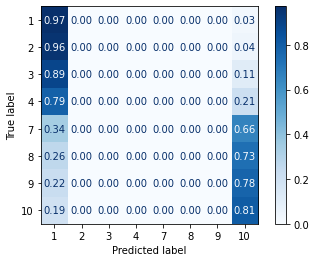

In [49]:
y_pred_train, y_pred_test, y_pred_test_class = predict(classifier, x_train, x_test)
print_evaluation(y_test, y_pred_test, y_pred_test_class)

## Classification with logistic regression

In [ ]:
text_clf = Pipeline([
    ('vect' CountVectorizer())
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
}
classifier = GridSearchCV(text_clf, parameters, scoring=make_scorer(r2_score), cv=5, n_jobs=-1)
classifier = classifier.fit(x_train, y_train)
print(f"Best parameters: {classifier.best_params_}")

In [ ]:
y_pred_train, y_pred_test, y_pred_test_class = predict(classifier, x_train, x_test)
print_evaluation(y_test, y_pred_test, y_pred_test_class)

## Classification with another classifier

In [ ]:
text_clf = Pipeline([
    ('vect' CountVectorizer())
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=RANDOM_SEED, loss='hinge', penalty='l2', alpha=1e-3, max_iter=500, tol=None)),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}
classifier = GridSearchCV(text_clf, parameters, scoring=make_scorer(r2_score), cv=5, n_jobs=-1)
classifier = classifier.fit(x_train, y_train)
print(f"Best parameters: {classifier.best_params_}")

In [ ]:
y_pred_train, y_pred_test, y_pred_test_class = predict(classifier, x_train, x_test)
print_evaluation(y_test, y_pred_test, y_pred_test_class)